In [1]:
# Import necessary libraries
from IPython.display import display, HTML
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

random_state = 42


In [2]:
# Load boston housing dataset
housing = load_boston()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=["MEDV"])

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

In [3]:
# Compute and print permutation feature importance
def pfi():
    r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=random_state)
    x = []
    y = []
    error = []
    for i in r.importances_mean.argsort()[::-1]:
        y.append(housing.feature_names[i])
        x.append(r.importances_mean[i])
        error.append(r.importances_std[i])

    # Plotting the bar graph
    plt.barh(y, x, align='center', alpha=0.5)
    plt.errorbar(x, y, xerr=error, linestyle='None', color='black')

    # Customizing the plot
    plt.gca().invert_yaxis()
    plt.xlabel('Mean feature importance value')
    plt.title(f'{model_name}: PFI + Std Dev error bar')
    plt.show()


In [4]:
# Compute SHAP values and plot summary
def shapley():
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_train)
    shap.plots.bar(shap_values, show=False)

    plt.title(f'SHAP Summary for {model_name}')
    plt.show()


In [8]:
# Compute LIME explanations for a random instance in the test set
def local_surr(i):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=housing.feature_names,
                                                       class_names=['MEDV'], mode='regression')

    exp = explainer.explain_instance(X_test.values[i], model.predict, num_features=5)
    # display(HTML(exp.show_in_notebook(show_table=True)))

    # Print out the explanation in a more readable format
    print('Intercept:', exp.intercept[0])
    for feature in exp.as_list():
        print('Feature:', feature[0])
        print('Weight:', feature[1])

    # Plot LIME feature importance
    features, weights = zip(*exp.as_list())
    plt.barh(features, weights)
    plt.xlabel("LIME Weight")
    plt.title(f"LIME Feature Importance for {model_name}, instance {i}")
    plt.gca().invert_yaxis()
    plt.show()


RandomForestRegressor - MSE: 7.901513892156864, MAE: 2.0395392156862746, R^2: 0.8922527442109116


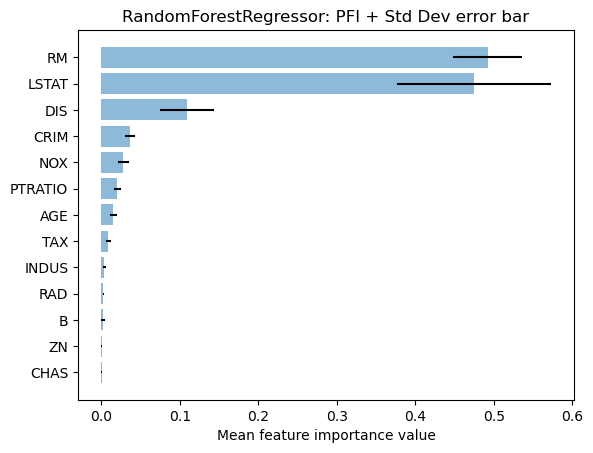

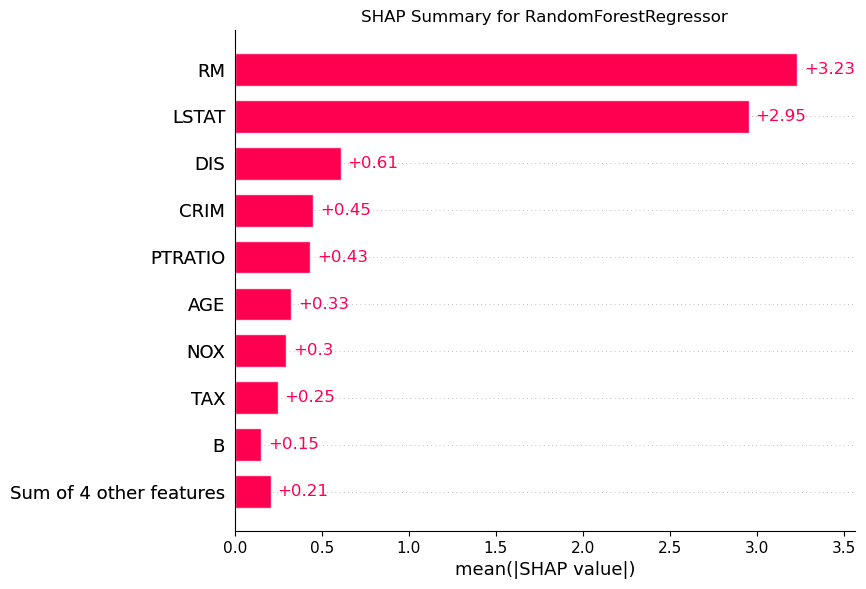

Intercept: 25.351068008815826
Feature: 5.89 < RM <= 6.21
Weight: -3.434059696763521
Feature: 10.93 < LSTAT <= 16.37
Weight: -1.520723264423642
Feature: DIS <= 2.09
Weight: 1.240968346434963
Feature: 18.70 < PTRATIO <= 20.20
Weight: -0.6435112772107033
Feature: CRIM > 3.20
Weight: -0.6140642352684235


X does not have valid feature names, but RandomForestRegressor was fitted with feature names


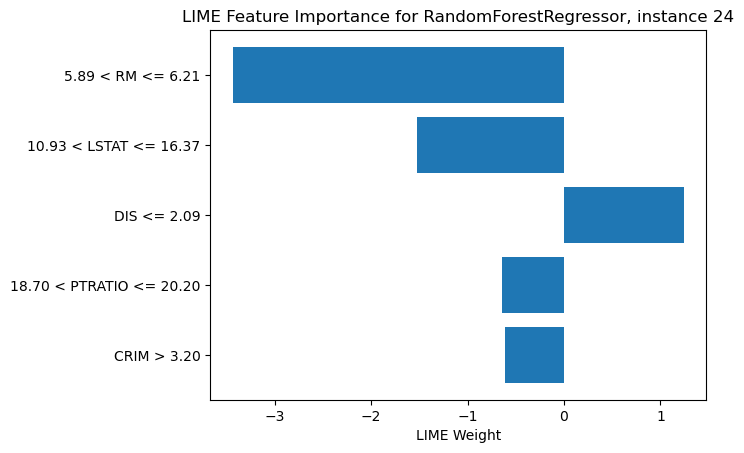

XGBRegressor - MSE: 6.560527271813469, MAE: 1.9574996602301502, R^2: 0.9105388132305845


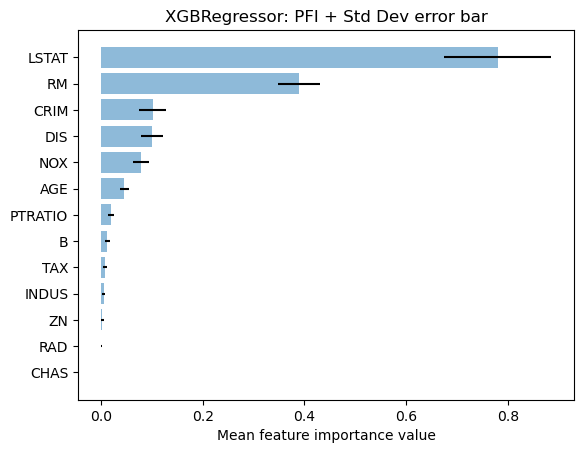

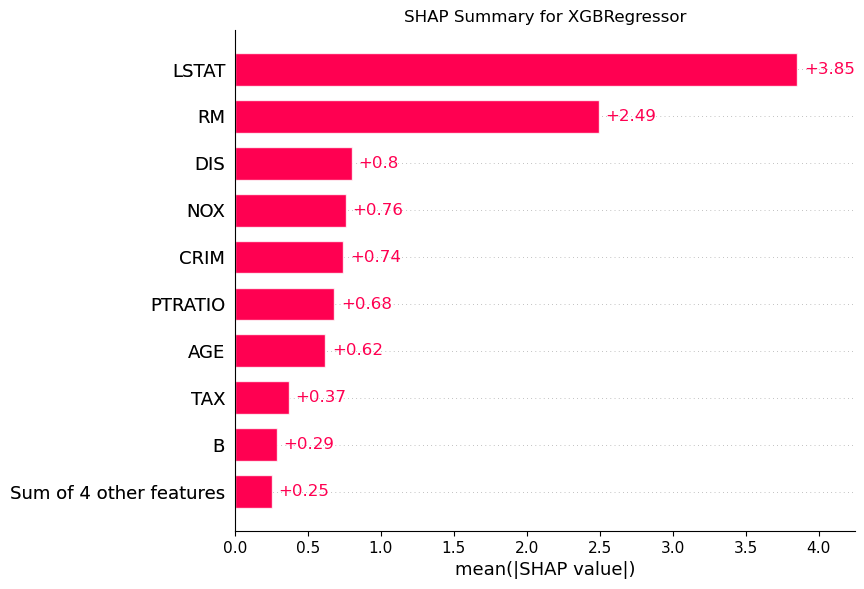

Intercept: 25.480577937240376
Feature: 10.93 < LSTAT <= 16.37
Weight: -3.2378657089953276
Feature: 5.89 < RM <= 6.21
Weight: -2.1068011307007684
Feature: DIS <= 2.09
Weight: 1.5724725443827365
Feature: NOX > 0.63
Weight: -1.1969556456561912
Feature: AGE > 93.65
Weight: -1.1227394906107753


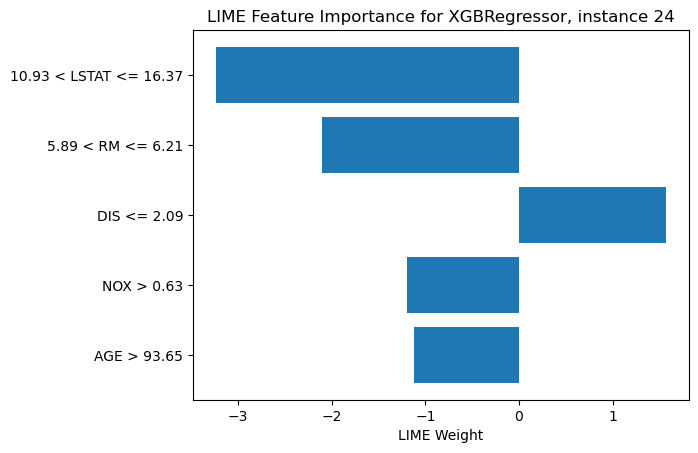

In [9]:
# Define the models
models = [
    ("RandomForestRegressor", RandomForestRegressor(n_estimators=100, random_state=random_state)),
    ("XGBRegressor", xgb.XGBRegressor(n_estimators=100, random_state=random_state))
]

i = np.random.randint(0, X_test.shape[0])

for model_name, model in models:
    # Train and evaluate each model
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse}, MAE: {mae}, R^2: {r2}")

    pfi()
    shapley()
    local_surr(i)


In [7]:
print(housing.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu